In [29]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tables
import pandas as pd
import zipfile
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA
import matminer.datasets as md
from matminer.datasets import load_dataset
import ase
from ase import Atoms
from ase.io import read, write, iread
from rascal.representations import SphericalInvariants as SOAP
from itertools import islice
from cur import cur_decomposition
from numpy.linalg import pinv as inv
import sys, os
import math

# Librascal
from rascal.representations import SphericalInvariants as SOAP

sys.path.append('./kernel-tutorials/')
# Local Utilities for Notebook
from utilities.general import FPS, center_matrix, normalize_matrix, load_variables
from utilities.kernels import linear_kernel, gaussian_kernel, center_kernel
from utilities.general import load_variables, get_stats
from utilities.plotting import (
    plot_base, 
    plot_projection,
    plot_regression,
    plot_simple,
    get_cmaps,
    table_from_dict,
    check_mirrors,
)
from utilities.general import FPS, center_matrix, normalize_matrix, load_variables
from utilities.kernels import linear_kernel, gaussian_kernel, center_kernel
from operator import itemgetter 
cmaps = get_cmaps()
plt.style.use("./kernel-tutorials/utilities/kernel_pcovr.mplstyle")
dbl_fig = (2 * plt.rcParams["figure.figsize"][0], plt.rcParams["figure.figsize"][1])

#skcosmo

from skcosmo.preprocessing import SparseKernelCenterer as SKC
from skcosmo.decomposition import PCovR
import random

from sklearn.datasets import load_iris
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.preprocessing import StandardScaler
from chemiscope import write_input
import json
from cur import cur_decomposition
from numpy.linalg import pinv as inv

from scipy.spatial import Voronoi, voronoi_plot_2d, ConvexHull, convex_hull_plot_2d, SphericalVoronoi
import landlab
from landlab import VoronoiDelaunayGrid
from landlab.grid.voronoi  import simple_poly_area
from scipy.spatial import Delaunay
from landlab import RasterModelGrid
from shapely.geometry import LineString
from shapely.ops import polygonize, unary_union


In [11]:
#unit normal vector of plane defined by points a, b, and c
def unit_normal(a, b, c):
    x = np.linalg.det([[1,a[1],a[2]],
         [1,b[1],b[2]],
         [1,c[1],c[2]]])
    y = np.linalg.det([[a[0],1,a[2]],
         [b[0],1,b[2]],
         [c[0],1,c[2]]])
    z = np.linalg.det([[a[0],a[1],1],
         [b[0],b[1],1],
         [c[0],c[1],1]])
    magnitude = (x**2 + y**2 + z**2)**.5
    return (x/magnitude, y/magnitude, z/magnitude)

#area of polygon poly
def poly_area(poly):
    if len(poly) < 3: # not a plane - no area
        return 0
    total = [0, 0, 0]
    N = len(poly)
    for i in range(N):
        vi1 = poly[i]
        vi2 = poly[(i+1) % N]
        prod = np.cross(vi1, vi2)
        total[0] += prod[0]
        total[1] += prod[1]
        total[2] += prod[2]
    result = np.dot(total, unit_normal(poly[0], poly[1], poly[2]))
    return abs(result/2)

In [8]:
"""TO FILE MP_db.zip for any necessity - MP_dataset.zip has all entries, also the NaN ones and is much longer"""

# df = load_dataset("mp_all_20181018")
# df.dropna(inplace=True)
# df.reset_index(drop=True, inplace=True)

# """Converting pymatgen core structure t ASE atoms obkect for SOAP vectors calculation"""

# def get_atoms(structure, **kwargs):
#         """
#         Returns ASE Atoms object from pymatgen structure or molecule.
#         Args:
#             structure: pymatgen.core.structure.Structure or pymatgen.core.structure.Molecule
#             **kwargs: other keyword args to pass into the ASE Atoms constructor
#         Returns:
#             ASE Atoms object
#         """
#         symbols = [str(site.specie.symbol) for site in structure]
#         positions = [site.coords for site in structure]
#         if hasattr(structure, "lattice"):
#             cell = structure.lattice.matrix
#             pbc = True
#         else:
#             cell = None
#             pbc = None
#         return Atoms(symbols=symbols, positions=positions, pbc=pbc, cell=cell, **kwargs)
    
# """Creating 'MP.xyz' file with MP data to use every time it is needed"""
    
# ase_frames=[]
# for i in df['initial structure']:
#     frame=get_atoms(i)
#     frame.wrap(eps=1e-10)
#     print(type(frame))
#     ase_frames.append(frame)
    
# xyz=ase.io.write('MP.xyz', ase_frames)
    
# # compression_opts = dict(method='zip',

# #                         archive_name='MP_db.csv')  

# # df.to_csv('MP_db.zip', index=False,

# #           compression=compression_opts)  

# # # df.to_csv('MP_dataset.csv')
# # # df.to_hdf('./MP.h5', 'data')
# # # df.to_pickle('MPdf.df')


'TO FILE MP_db.zip for any necessity - MP_dataset.zip has all entries, also the NaN ones and is much longer'

In [50]:
"""The file has been created in zip format, reading it"""
zf = zipfile.ZipFile('./MP_db.zip') 
df_csv = pd.read_csv(zf.open('MP_db.csv'), usecols=['e_hull','gap pbe', 'mu_b','structure', 'elastic anisotropy','bulk modulus', 'shear modulus', 'e_form'])

formE=df_csv['e_form']

"""Counting number of atoms from string"""   

def natoms(string):
    for item in string:
        if string[(string.find('Sites'))+8] == ')':
            n=(string.find('Sites'))+7
            return int(string[n])
        else:
            n1=(string.find('Sites'))+7
            n2=(string.find('Sites'))+8
            return int(string[n1]+string[n2])
        
natoms_list=[]
for i in range(len(df_csv)):
    natoms_list.append(natoms(df_csv['structure'][i]))
    
print(len(formE), len(natoms_list))

7676 7676


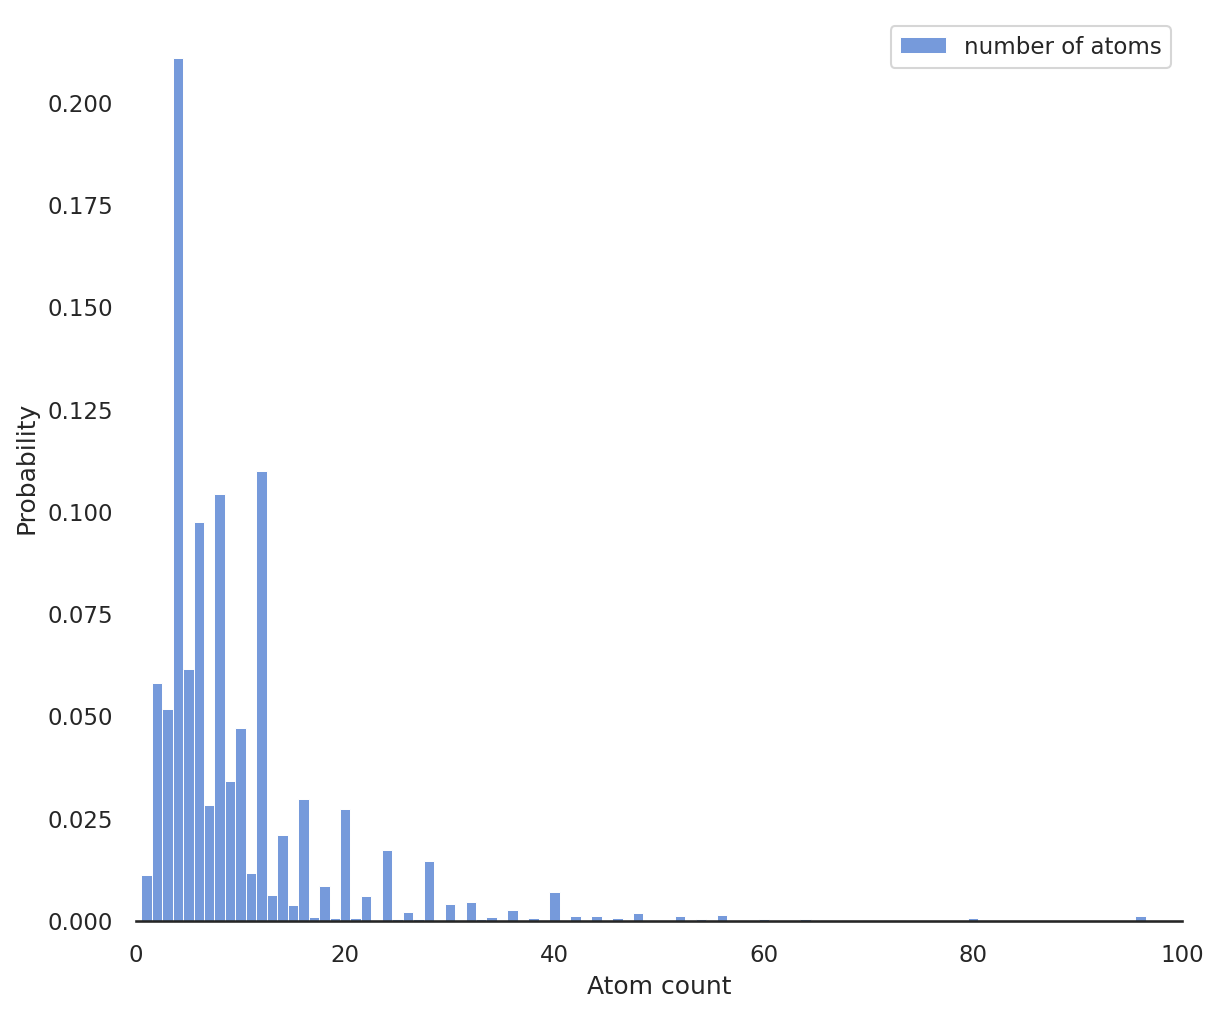

In [51]:
"""Plotting number of atoms in unit cell"""

sns.set(style="white", palette="muted", color_codes=True)
f, ax = plt.subplots(figsize=(9, 8))
sns.despine(left=True)
sns.histplot(data=natoms_list, stat="probability", color='b', discrete=True, label='number of atoms')
ax.set_xlabel('Atom count')
plt.legend()
plt.xlim(0,100)
# plt.savefig('MP_natom_occ.png', bbox_inches='tight', dpi=400)
plt.show()
plt.close()

In [52]:
"""Adding magic and number of atoms to dataframe""" 

# df_csv['number atoms'] = natoms_list

# magic=[None] * len(df_csv)
# for i in range(len(df_csv)):
#     if df_csv['number atoms'][i]%4==0:
#         magic[i]=1
#     else:
#         magic[i]=0
# len(magic)
# df_csv['magic?']=magic

'Adding magic and number of atoms to dataframe'

In [53]:
df_csv.head()

,e_hull,gap pbe,mu_b,elastic anisotropy,bulk modulus,shear modulus,structure,e_form
0,0.003319,0.0000,2.700000e-05,1.044699,33.154748,4.904836,Full Formula (In1)\nReduced Formula: In\nabc ...,0.003319
1,0.039182,0.0000,-1.360000e-05,-11.326659,35.636106,1.830272,Full Formula (Mg1)\nReduced Formula: Mg\nabc ...,0.039182
2,0.108143,0.0000,1.000000e-07,8.030000,124.000000,84.000000,Full Formula (Be4)\nReduced Formula: Be\nabc ...,0.108143
3,0.071216,0.0000,-2.050000e-05,0.881277,101.242732,44.836516,Full Formula (Hf1)\nReduced Formula: Hf\nabc ...,0.071216
4,3.509988,2.0113,3.000042e+00,10.884643,0.327165,-0.064038,Full Formula (P1)\nReduced Formula: P\nabc :...,3.509988


In [55]:
select=5000
frames_ase=[]
iso_q=[]
natoms=[]

ase_fra=random.sample(ase.io.read('MP.xyz', index=':'), select)
for frame in ase_fra:
    frame.wrap(eps=1e-10)
    pos=frame.get_positions()
    
    try:
        vor=Voronoi(pos)
    except: 
        continue
    if len(frame)==1:
        continue
    frames_ase.append(frame)
    natom = len(frame)
    natoms.append(natom)
    vol=atoms.get_volume()
    vor=Voronoi(pos)  
    polygons = {}
    for id, region_index in enumerate(vor.point_region):
        points = []
        for vertex_index in vor.regions[region_index]:
            if vertex_index != -1:  # the library uses this for infinity
                points.append(list(vor.vertices[vertex_index]))
                
        points.append(points[0])    
        polygons[id]=points 
    
    a_tot = sum(poly_area(polygons[i]) for i in range(len(polygons)))
    iso=36*math.pi*vol**2/(a_tot**3)
    iso_q.append(iso)
len(iso_q)

<ipython-input-11-b1dfcc80c8d8>:13: RuntimeWarning: invalid value encountered in double_scalars
  return (x/magnitude, y/magnitude, z/magnitude)
<ipython-input-55-90fe0453ee09>:33: RuntimeWarning: divide by zero encountered in double_scalars
  iso=36*math.pi*vol**2/(a_tot**3)


3721

No handles with labels found to put in legend.


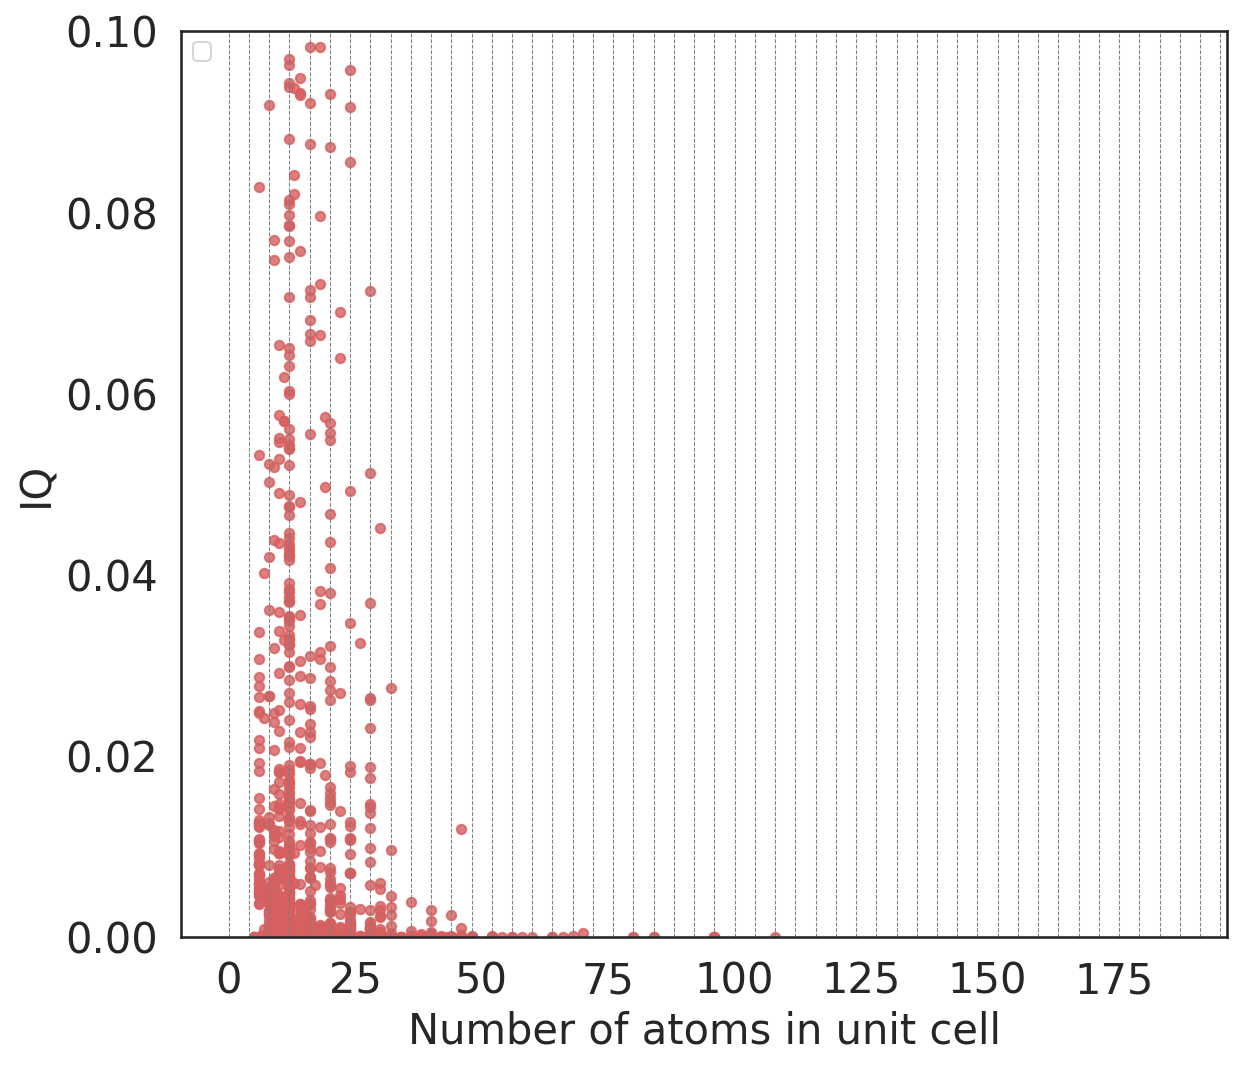

2143

In [56]:
    
def remove_zeros(lista):
    idx=[l for l in range(len(lista)) if np.isinf(lista[l])!=True and np.isnan(lista[l])!=True]
    return idx

indexes=remove_zeros(iso_q)
IQ= list(itemgetter(*indexes)(iso_q))
natoms_red=list(itemgetter(*indexes)(natoms))
frames_ase=list(itemgetter(*indexes)(frames_ase))


No handles with labels found to put in legend.


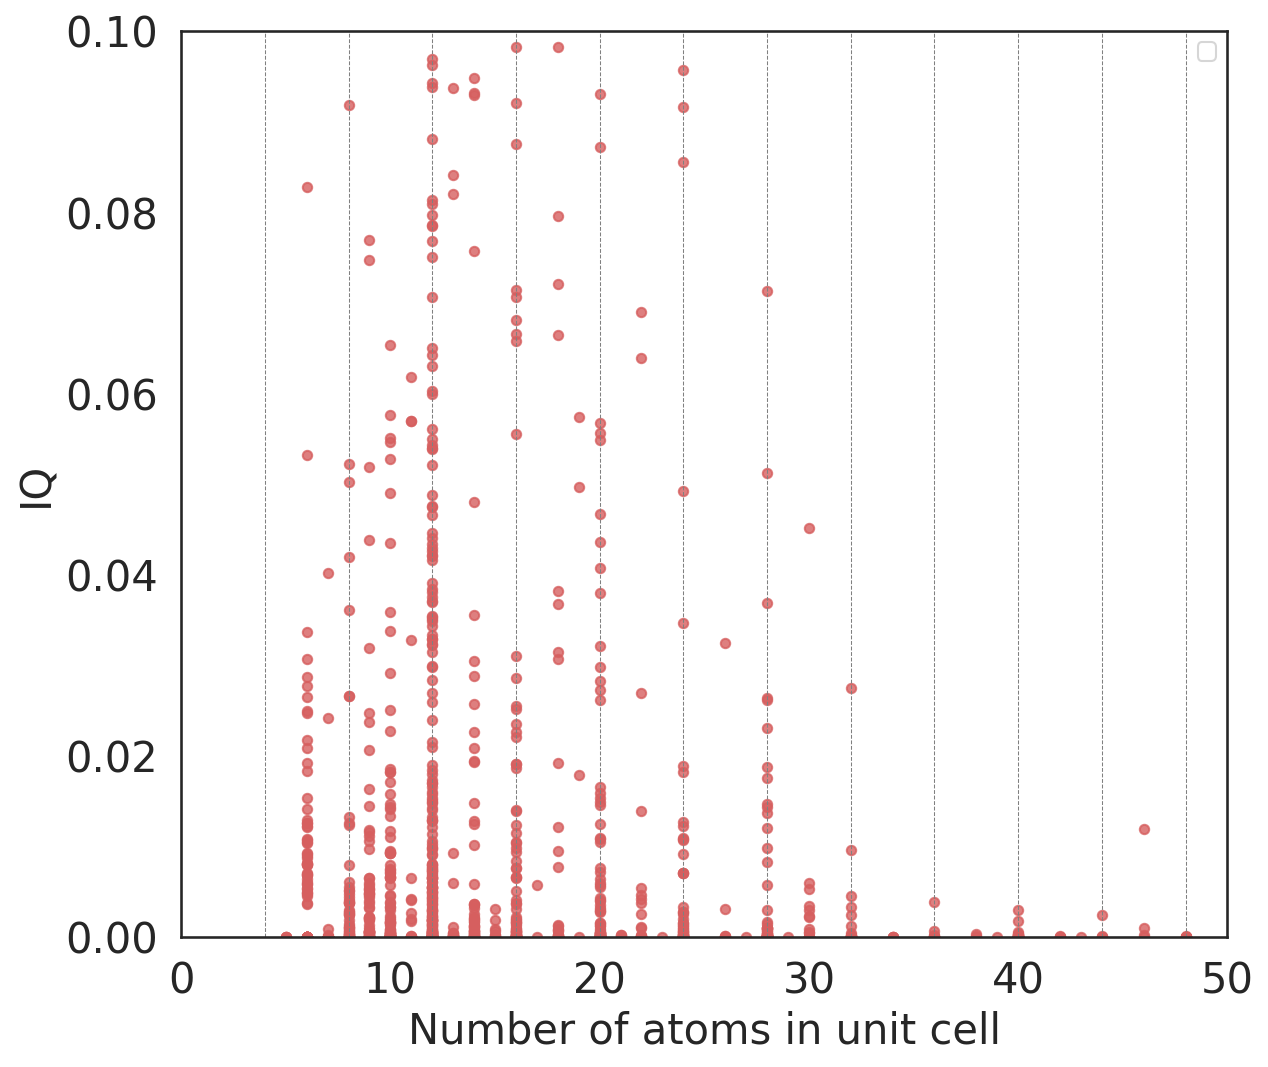

2143

In [57]:
plt.figure(figsize=(9, 8))
plt.scatter (natoms_red, IQ, s=20, alpha=0.8, c='r')
plt.legend()
plt.xlabel("Number of atoms in unit cell", size=20)
for i in range(0,200,4):
    plt.axvline(x=i, linestyle='--', c='grey', lw=0.5)
# plt.ylim(0.05, 1)
plt.ylabel("IQ", size=20)
plt.yticks(size=20)
plt.xticks(size=20)
plt.xlim(0,50)
plt.ylim(0,0.1)
# plt.savefig("element rel occ.png", bbox_inches='tight', dpi=400)
plt.show()
plt.close()

len(IQ)

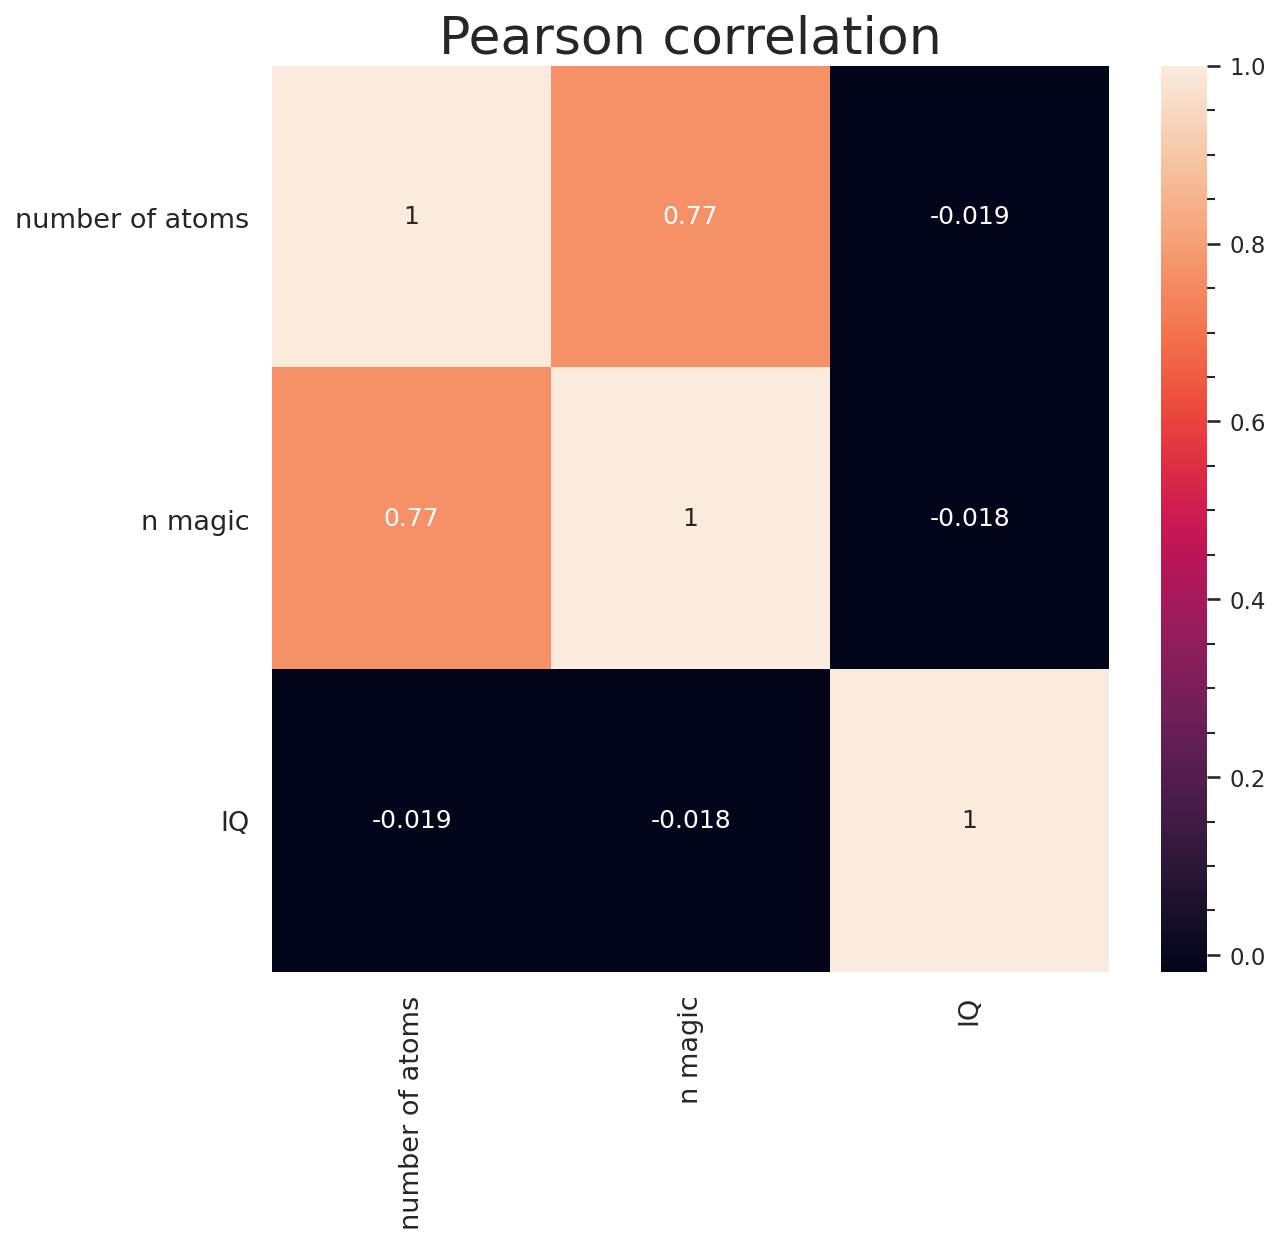

NameError: name 'scatter_matrix' is not defined

In [58]:
na_mod=natoms_red.copy()
for (i, item) in enumerate(natoms_red):
    if item %4!=0:
        na_mod[i] = 0
# print(type(volume), type(natoms), type(na_mod))   
data= {'number of atoms': natoms_red,
       'n magic':na_mod, 
       'IQ': IQ        
      }

df = pd.DataFrame(data,columns=['number of atoms','n magic', 'IQ'])
fig, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(df.corr(), annot=True)
ax.tick_params(labelsize=13, direction='out')
plt.yticks(rotation=0) 
plt.xticks(rotation=90) 
plt.title('Pearson correlation', size=25)
# plt.savefig("CM.png", bbox_inches='tight', dpi=400)
plt.show()

titles=['number of atoms','n magic', 'IQ']

scatter_matrix(df[titles], figsize=(15, 15))

In [ ]:
print(len(ase_fra))
# ase_fr=ase.io.iread('MP.xyz')

soap = SOAP(soap_type='PowerSpectrum',
           interaction_cutoff=3.5,
           max_radial=6,
           max_angular=6,
           gaussian_sigma_type='Constant',
           gaussian_sigma_constant=0.4,
           cutoff_smooth_width=0.5)


soap_rep = soap.transform(ase_fra)
X_raw = soap_rep.get_features(soap)
num_features = X_raw.shape[1]
print(soap)


"""Checking how many rows with all 0.0 entries are there"""
p = np.where(X_raw != 0)
type(p)
X_raw_new = X_raw[min(p[0]) : max(p[0]) + 1, min(p[1]) : max(p[1]) + 1]
print('There are '+str(X_raw.shape[0]-X_raw_new.shape[0])+' rows with all zero entries that are slowing down the calculation and do not contribute to SOAP vector')

X_raw.shape

In [4]:
r = 100
C_cur, U, R = cur_decomposition (X_raw, r)
X_raw.shape, C_cur.shape, U.shape, R.shape

((1488, 86184), (1488, 100), (100, 100), (100, 86184))

In [5]:
# FPS the components
print(f"Each SOAP vector contains {num_features} components.\
       \nWe use furthest point sampling to generate a subsample of our SOAP vectors.")

n_FPS=100
col_idxs, col_dist = FPS(X_raw.T, n_FPS)
X_FPS = X_raw[:, col_idxs]
X_FPS.shape

Each SOAP vector contains 86184 components.       
We use furthest point sampling to generate a subsample of our SOAP vectors.


(1488, 100)

In [6]:
l=np.concatenate(ase_fra)
len(l)
Y=np.zeros((len(l), 1))

natoms_list=[]
start=0
for frame in ase_fra:
    natoms=(len(frame))
#     Y[start:int(start+natoms), 0] = int(natoms)
    if natoms%4==0:
        Y[start:int(start+natoms)] = int(2)
    else:
        Y[start:int(start+natoms)] = int(1)
#         Y[start:int(start+natoms), 1] == 1
#     else:
#         Y_natoms[start:int(start+natoms), 0] == 2 
#         Y_natoms[start:int(start+natoms), 1] == 2 
# #         ax.scatter(X_ipca[start:int(start+natoms) , 0], X_ipca[start:int(start+natoms), 1], c='b', alpha=0.2)
    start=start+natoms
Y.shape

(1488, 1)

Shape of testing FPS data is: (744, 100), ||X|| = 17.93612836033564.
Shape of testing CUR data is: (744, 100), ||X|| = 28.240297687030534.


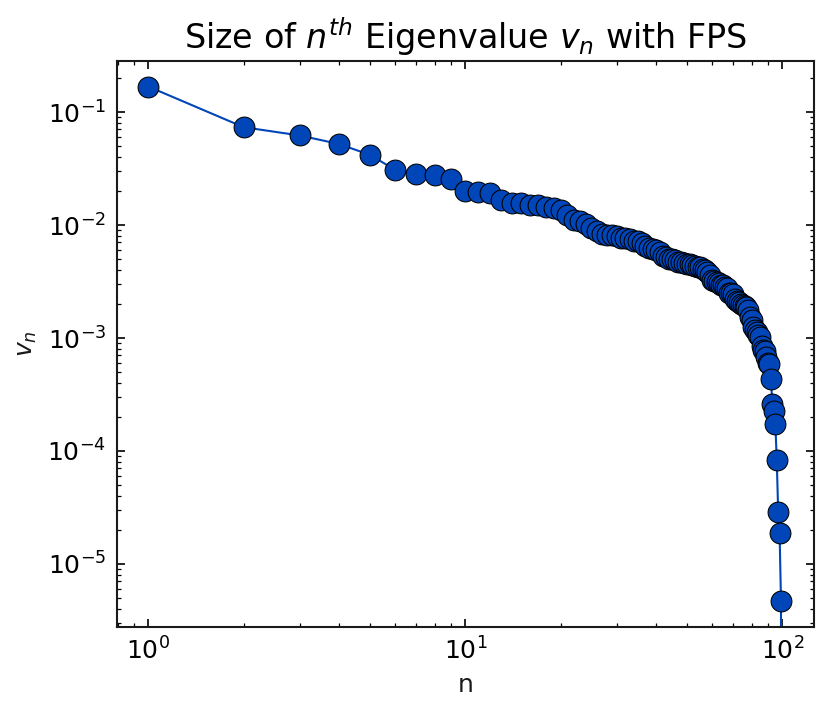

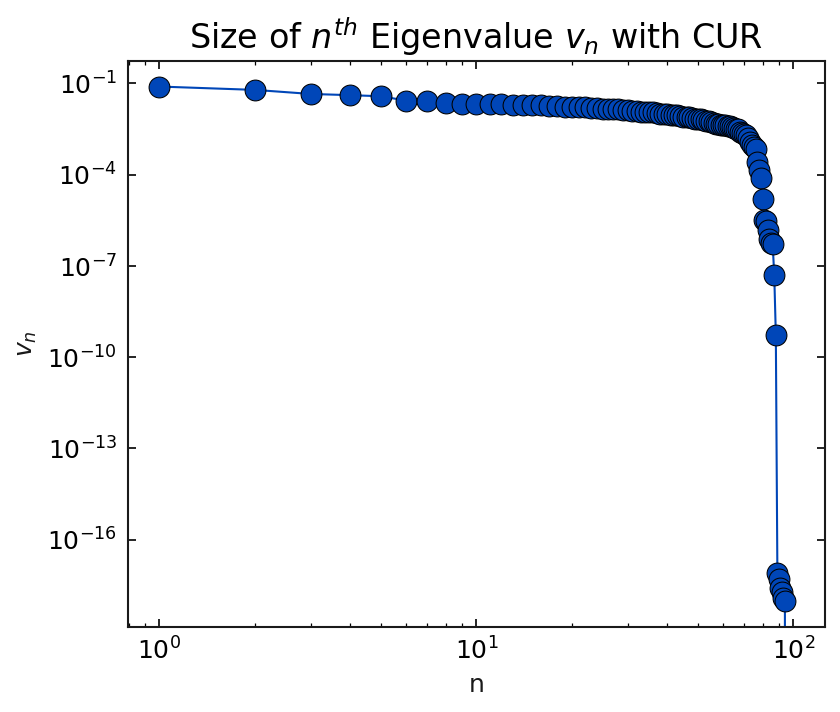

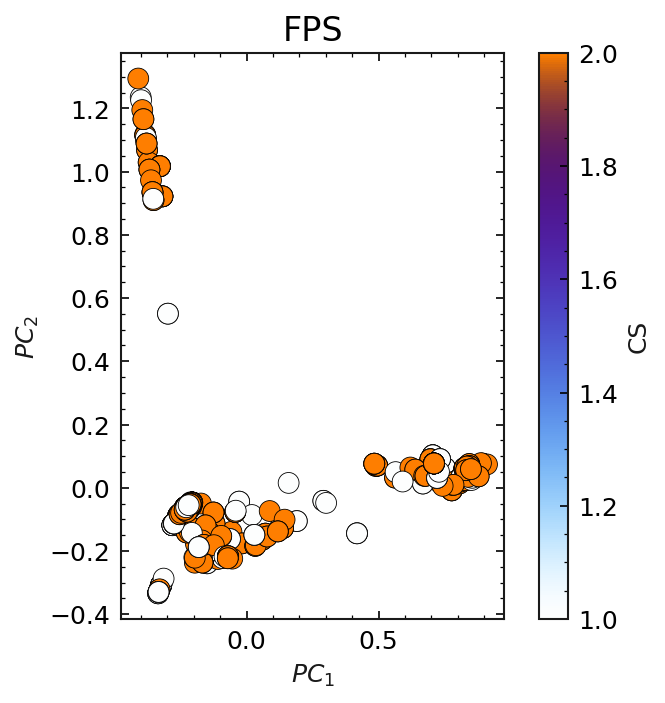

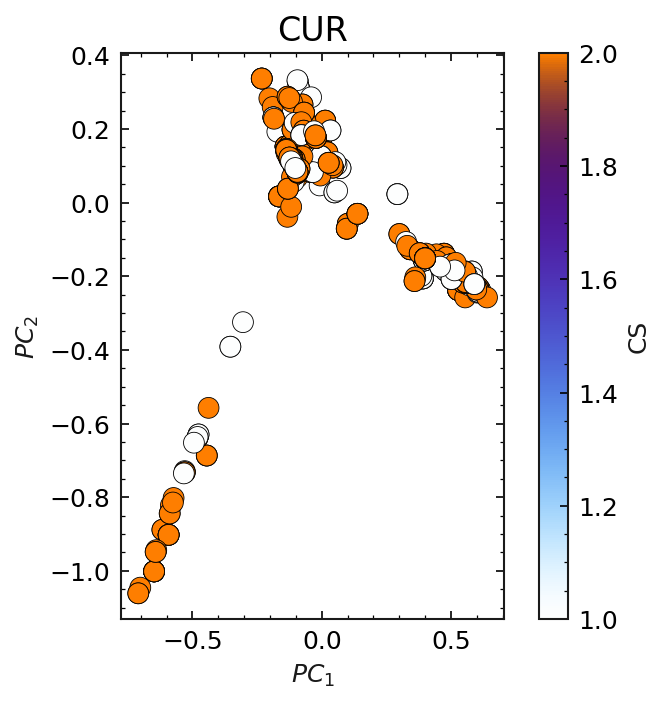

In [7]:
# Splits in train and test sets
X1=np.copy(X_FPS)
X2=np.copy(C_cur)

n_train = int(len(Y)/2)
n_test = len(Y)-n_train
r_train = np.asarray(range(len(Y)))
np.random.shuffle(r_train)
i_test = list(sorted(r_train[n_train:]))
i_train = list(sorted(r_train[:n_train]))

X1_train = X1[i_train]
X2_train = X2[i_train]
Y_train = Y[i_train]
X1_test = X1[i_test]
X2_test = X2[i_test]
Y_test = Y[i_test]

print(f'Shape of testing FPS data is: {X1_train.shape}, ||X|| = {np.linalg.norm(X1_train)}.') 
print(f'Shape of testing CUR data is: {X2_train.shape}, ||X|| = {np.linalg.norm(X2_train)}.') 

X1_center = X1_train.mean(axis=0)
X2_center = X2_train.mean(axis=0)
# Y_center = Y_train.mean(axis=0)

# Center total dataset
X1 = center_matrix(X1, center=X1_center)
X2 = center_matrix(X2, center=X2_center)
# Y = center_matrix(Y, center=Y_center)

# Center training data
X1_train = center_matrix(X1_train, center=X1_center)
X2_train = center_matrix(X2_train, center=X2_center)
# Y_train = center_matrix(Y_train, center=Y_center)

# Center testing data
X1_test = center_matrix(X1_test, center=X1_center)
X2_test = center_matrix(X2_test, center=X2_center)
# Y_test = center_matrix(Y_test, center=Y_center)

# Calculate the scale of the training data
X1_scale = np.linalg.norm(X1_train) / np.sqrt(n_train)
X2_scale = np.linalg.norm(X2_train) / np.sqrt(n_train)
# Y_scale = np.linalg.norm(Y_train) / np.sqrt(n_train)

# Scale the total dataset
X1 = normalize_matrix(X1, scale=X1_scale)
X2 = normalize_matrix(X2, scale=X2_scale)
# Y = normalize_matrix(Y, scale=Y_scale)

# Scale the training data
X1_train = normalize_matrix(X1_train, scale=X1_scale)
X2_train = normalize_matrix(X2_train, scale=X2_scale)
# Y_train = normalize_matrix(Y_train, scale=Y_scale)

# Scale the testing data
X1_test = normalize_matrix(X1_test, scale=X1_scale)
X2_test = normalize_matrix(X2_test, scale=X2_scale)
# Y_test = normalize_matrix(Y_test, scale=Y_scale)

C1 = X1_train.T @ X1_train
C2 = X2_train.T @ X2_train


v_C1, U_C1 = np.linalg.eigh(C1)
v_C2, U_C2 = np.linalg.eigh(C2)


# U_C/v_C are already sorted, but in *increasing* order, so reverse them
U_C1= np.flip(U_C1, axis=1)
v_C1= np.flip(v_C1, axis=0)

U_C2= np.flip(U_C2, axis=1)
v_C2= np.flip(v_C2, axis=0)

plt.loglog(np.asarray(range(len(v_C1))) + 1, v_C1 / n_train, marker="o")
plt.title(r"Size of $n^{th}$ Eigenvalue $v_n$ with FPS")
plt.xlabel("n")
plt.ylabel(r"$v_n$")
plt.show()
plt.close()
plt.loglog(np.asarray(range(len(v_C2))) + 1, v_C2 / n_train, marker="o")
plt.title(r"Size of $n^{th}$ Eigenvalue $v_n$ with CUR")
plt.xlabel("n")
plt.ylabel(r"$v_n$")
plt.show()
plt.close()

n_PC=100
PXT1 = U_C1[:, :n_PC]
PTX1 = PXT1.T

PXT2 = U_C2[:, :n_PC]
PTX2 = PXT2.T

T1 = X1_train @ PXT1
T2 = X2_train @ PXT2

# print(PXT1.shape, X1_train.shape,  T1.shape,
#       PXT2.shape, X2_train.shape,  T2.shape, Y_train.shape)

plot_projection(Y_train, T1, **cmaps, title='FPS')
plt.show()
plt.close()
plot_projection(Y_train, T2, **cmaps, title='CUR')

plt.savefig('PCA_tutorial_mixed_db.png', bbox_inches= 'tight', dpi=700)

In [1]:
print(pca_array.shape)
n_components = 2
ipca = IncrementalPCA(n_components=n_components, batch_size=25)
X_ipca_combined = ipca.fit_transform(pca_array)


# df_array = red_df.values
scaler=StandardScaler()#instantiate
scaler.fit(pca_array) # compute the mean and standard which will be used in the next command
X_scaled=scaler.transform(pca_array)# fit and transform can be applied together and I leave that for simple exercise 
pca=PCA(n_components=2) 
pca.fit(X_scaled)
X_pca = pca.fit_transform(X_scaled)
# ipca = IncrementalPCA(n_components=n_components, batch_size=10)



NameError: name 'pca_array' is not defined

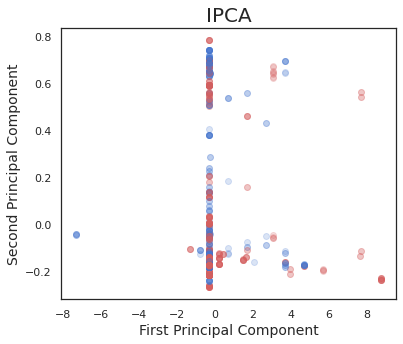

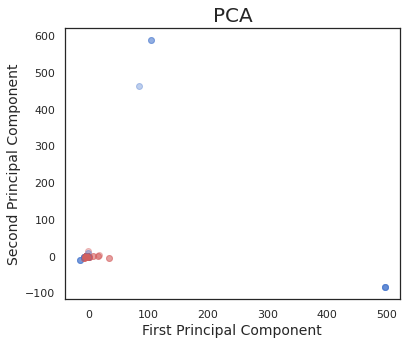

In [16]:
ig,ax=plt.subplots(figsize=(6,5))
start=0
for frame in ase_fra:
    natoms=(len(frame))
#     print(start, natoms)
    if natoms%4==0:
        ax.scatter(X_ipca_combined[start:int(start+natoms), 0], X_ipca_combined[start:int(start+natoms), 1],c='r', alpha=0.2)
    else:
        ax.scatter(X_ipca_combined[start:int(start+natoms) , 0], X_ipca_combined[start:int(start+natoms), 1], c='b', alpha=0.2)
    start=start+natoms
        # plt.savefig('PCA_2.png', bbox_inches= 'tight', dpi=400 )

plt.title("IPCA",fontsize=20)
plt.xlabel("First Principal Component",fontsize=14)
plt.ylabel("Second Principal Component",fontsize=14)
plt.savefig('IPCA_MP_combined.png', bbox_inches= 'tight', dpi=700 )
plt.show()
plt.close()

ig,ax=plt.subplots(figsize=(6,5))
start=0
for frame in ase_fra:
    natoms=(len(frame))
#     print(start, natoms)
    if natoms%4==0:
        ax.scatter(X_pca[start:int(start+natoms), 0], X_pca[start:int(start+natoms), 1],c='r', alpha=0.2)
    else:
        ax.scatter(X_pca[start:int(start+natoms) , 0], X_pca[start:int(start+natoms), 1], c='b', alpha=0.2)
    start=start+natoms
        # plt.savefig('PCA_2.png', bbox_inches= 'tight', dpi=400 )

plt.title("PCA",fontsize=20)
plt.xlabel("First Principal Component",fontsize=14)
plt.ylabel("Second Principal Component",fontsize=14)
plt.savefig('PCA_MP_combined.png', bbox_inches= 'tight', dpi=700 )
plt.show()
plt.close()


[0. 0. 1. ... 0. 1. 0.]
0.0
1.0


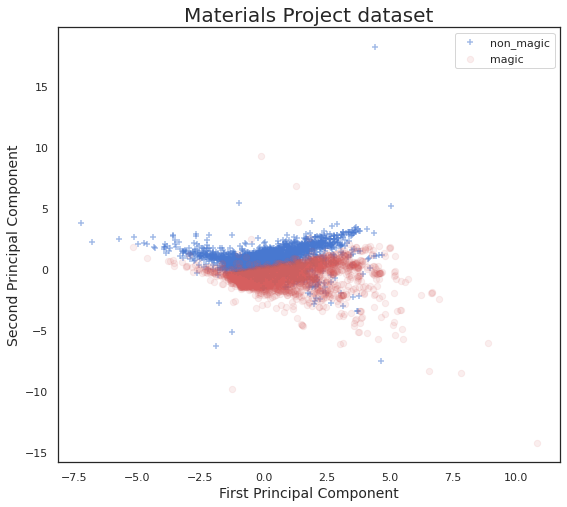

In [38]:
Xax=X_pca[:,0]
Yax=X_pca[:,1]
labels=np.asarray(df_array[:,8])
print(labels)
cdict={0:'b',1:'r'}
labl={0:'non_magic',1:'magic'}
marker={0:'+',1:'o'}
alpha={0:.5, 1:.1}

fig,ax=plt.subplots(figsize=(9,8))

for l in np.unique(labels):
    print(l)
    
    ix=np.where(labels==l)
    ax.scatter(Xax[ix],Yax[ix],c=cdict[l],s=40,
           label=labl[l],marker=marker[l],alpha=alpha[l])# for loop ends
         
plt.title("Materials Project dataset",fontsize=20)
plt.xlabel("First Principal Component",fontsize=14)
plt.ylabel("Second Principal Component",fontsize=14)
plt.legend()
plt.savefig('PCA_MP', bbox_inches= 'tight', dpi=700 )
plt.show()# please check the scatter plot of the remaining component and you will understand the difference

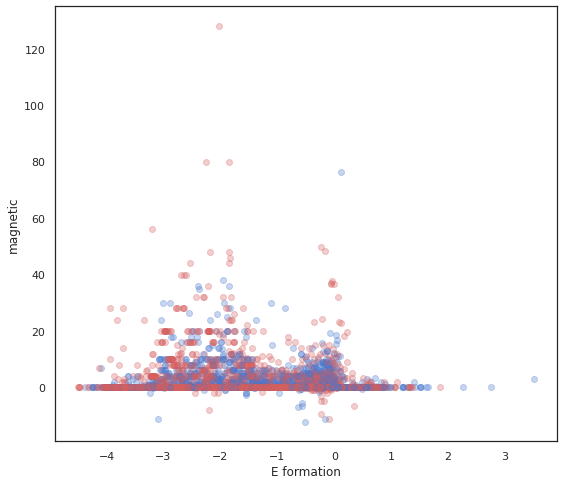

In [23]:
# def clean_dataset(df):
#     assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
#     df.dropna(inplace=True)
#     indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
#     return df[indices_to_keep].astype(np.float64)
# clean_df=clean_dataset(df)

plt.figure(figsize=(9, 8))  
for i in range(7675):
    if int(df_array[i,8])==1:
        plt.scatter(df_array[i,6], df_array[i,2], color='r', alpha=0.3)
    else:
        plt.scatter(df_array[i,6], df_array[i,2], color='b', alpha=0.3)

plt.xlabel('E formation',fontsize=12)
plt.ylabel('magnetic',fontsize=12)
plt.savefig('scatterMP.png', bbox_inches= 'tight', dpi=400 )
plt.show()